# sprint14課題 ディープラーニングフレームワーク1

In [1]:
#インポート
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

# TensorFlow入門1 基本的な仕組み

## 簡単な計算 
簡単な計算をさせてみます。TensorFlowの基本的な流れです。

In [2]:
import tensorflow as tf

a = tf.constant(5)
b = tf.constant(7)
add = tf.add(a, b)

sess = tf.Session()
output = sess.run(add)
print(output) # 12
sess.close()

12


7行目のsess = tf.Session()からsess.close()はwithを使って以下のように書くこともできます。

In [3]:
with tf.Session() as sess:
    output = sess.run(add)
    print(output) # 12

12


比較のために、NumPyでも同じ計算をさせてみます。

In [4]:
import numpy as np
a_n = np.array(5)
b_n = np.array(7)
output_n = np.add(a_n, b_n)
print(output_n) # 12

12


このような簡単な計算例ではNumPyの方が短く記述可能です。  
TensorFlowの真価が発揮されるのは学習を行うような計算の際ですが、ここでは簡単な計算を例に理解を深めていくことにします。

## TensorFlowの手順
TensorFlowの手順は以下のようになっています。

- データフローグラフを構築する 
- データを入力して計算する  

簡単な計算の例でそれぞれを解説します。

## データフローグラフの構築
サンプルコードの以下の部分でデータフローグラフを構築しています。

In [5]:
a = tf.constant(5)
b = tf.constant(7)
add = tf.add(a, b)

定数aと定数bを定義し、それらを足し算するデータフローグラフです。  
NumPyであれば3行で計算まで行いますが、TensorFlowでは実際の計算までは進みません。  
それぞれをprintしてみても、エッジ（Tensor）の説明が返されるだけです。

In [6]:
print(a) # Tensor("Const:0", shape=(), dtype=int32)
print(add) # Tensor("Add:0", shape=(), dtype=int32)

Tensor("Const_2:0", shape=(), dtype=int32)
Tensor("Add_1:0", shape=(), dtype=int32)


### データを入力して計算
データフローグラフの計算を行う際にはセッションという概念が登場します。

まずSessionオブジェクトを作成します。

In [7]:
sess = tf.Session()

そして、sess.run()の中にエッジ（Tensor）を入れます。  
そうすることで、そのエッジ（Tensor）がどのような値を持つかが返ってきます。

In [8]:
output = sess.run(add)
print(output) # 12

12


データフローグラフやセッションの概念は、次のテキストでより複雑な計算を実装していくことで理解を深めます。

## TensorFlowにおける値の扱い方
TensorFlowが値を扱う上で独自の概念として、placeholderとValiableがあります。

**placeholder**

placeholderはデータフローグラフの構築時には値が決まっていないものに使います。  
最初は配列の形だけ定義しておいて後から値を入れて使う空箱のような存在です。   
学習ごとに違う値が入る入力データや正解データなどに用いられます。

サンプルコードをplaceholderを使用したものに書き換えてみます。

In [9]:
c = tf.placeholder(tf.int32)
d = tf.placeholder(tf.int32)
add = tf.add(c, d)

sess = tf.Session()
output = sess.run(add, feed_dict={c:5, d:7})
print(output) # 12

12


セッションを実行する際に引数feed_dictを使い、placeholderに入れる値を辞書型で指定します。  
ここを書き換えることで異なる計算が可能になります。

In [10]:
output = sess.run(add, feed_dict={c:20, d:32})
print(output) # 52

52


今回の簡単な例では定数とplaceholderの違いは感じられませんが、ミニバッチ学習を行うような場合を想定すると、必要性がわかります。  

**Valiable**

Valiableはplaceholderとは違い、データフローグラフの構築時にも値を持ち、更新を行うものに対して使います。  
学習するパラメータ（重み、バイアス）に用いられます。  

**constant**

確認になりますが、placeholderでもValiableでもないただの値は定数constantとして扱います。

## TensorFlowにおける演算
サンプルコードではtf.add()を使用していますが、NumPyなどと同様に+を使用することも可能です。

In [11]:
add = a + b # tf.add(a, b)に等しい

TensorFlowではNumPyなどと同様に様々な関数が用意されています。  

## セッションの終了  
最後にセッションは終了させます。

In [12]:
sess.close()

セッションのインスタンス化から終了までに対して、with構文を使うことも可能です。

In [13]:
with tf.Session() as sess:
    out = sess.run(add) # ここに計算の実行コードを入れていく

out

12

# TensorFlow入門2 ロジスティック回帰実装

TensorFlowを使いロジスティック回帰を実装していきます。  
入門1では単純な足し算でしたが、ここでは学習を伴う計算を行います。

## 論理回路
簡単な題材として、ロジスティック回帰による論理回路の再現を行います。  
論理回路は2つの値を入力し、1つの値を出力する関数のようなものです。  
入力も出力も0か1のみで表され、入力される組み合わせによって出力する値が変わります。  

ANDゲートは入力された2つの値が両方とも1だった場合、出力が1となり、それ以外の組み合わせでは0を出力します。

## データの作成
最初に学習用のトレーニングデータをNumPyにより作成しておきます。  
ANDゲートでは入力が2次元で出力が1次元となります。  
2つの入力が1のときだけ1を出力し、それ以外は0を出力するので以下のように定義できます。

In [14]:
x_train = np.array([[0,0],[0,1],[1,0],[1,1]])
y_train = np.array([[0],[0],[0],[1]])

TensorFlowによる実装に必要な次の2つのことを順番に見ていきます。

- データフローグラフを構築する
- データを入力して計算する 

## データフローグラフの構築
まずはデータフローグラフを構築します。  

学習データをTensorFlowのデータフローグラフに入力するための placeholder を用意しましょう。  
placeholderはデータフローグラフを作成する段階では値が決まっていない、空箱のような存在でした。

In [15]:
x = tf.placeholder(tf.float32, [None, 2])
t = tf.placeholder(tf.float32, [None, 1])

第一引数のtf.float32で行列要素の数値のデータ型を指定しています。  
第二引数の[None,2]で行列の形を指定しています。ここで定義されている2はデータの次元を表しています。  
Noneの部分はデータ数を表す部分です。今回のANDゲートの場合のデータ数は[0,0],[0,1],[1,0],[1,1]の4つしかないのでNoneの部分を[4,2]としても問題はありません。  
しかし、任意の数のデータを入れられるように、一般的にはNoneを使います。

重みとバイアスの Valiable を用意します。  
Valiableとして用意するということは、これらが学習により更新を行う値であることを示します。



In [16]:
W = tf.Variable(tf.zeros([2,1]))
b = tf.Variable(tf.zeros([1]))

Instructions for updating:
Colocations handled automatically by placer.


ここで、tf.Variable()の中でtf.zeros()という関数を呼び出していますが、初期値として0を入れているということです。  

次にモデルの出力y（＝仮定関数）と目的関数を定義します。  

ロジスティック回帰の式は以下でした。ここでは正則化項は抜かしています。  

$$
h_θ(x) = g(θ^T x).\\
g(z) = \frac{1}{1+e^{−z}}.\\
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))]
$$

$
m : 入力されるデータの数\\
h_θ() : 仮定関数\\
x : 特徴量ベクトル\\
θ : パラメータベクトル\\
g() : シグモイド関数\\
x^{(i)} : i番目のサンプルの特徴量ベクトル\\
y^{(i)}: i番目のサンプルの正解ラベル\\
θ_j : j番目のパラメータ（重み）\\
n : 特徴量の数\\
$


これをTensorFlowで記述すると次のようになります。

In [17]:
y = tf.sigmoid(tf.matmul(x, W) + b)
cross_entropy = tf.reduce_sum(-t * tf.log(y) - (1 - t) * tf.log(1 - y))

tf.matmul()はNumPyにおけるnp.dot()に相当するベクトルの内積や、行列積を計算するためのメソッドです。

なお、例えば回帰問題で二乗和誤差関数を使用するのであれば、tf.reduce_sum(tf.square(y - t))というように定義できます。  

ここまでで、入力のための空箱であるplaceholderと学習可能なValiableをメソッドで結ぶことができました。  

学習を行うために、勾配降下法を用いてパラメータを最適化するためのコードを加えます。  
目的関数をGradientDescentOptimizerに渡します。

In [18]:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

GradientDescentOptimizer()は引数で学習率を指定しています。  

学習後の結果の正解が正しいかどうかの判定と正解率の計算もデータフローグラフとして定義できます。

In [19]:
correct_prediction = tf.equal(tf.sign(y - 0.5), tf.sign(t - 0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

1行目で結果が正解かどうか判定しています。一つ一つ見ていきましょう。  
まずtf.equal()は引数に指定された2つの値が等しいかどうかを判定してくれます。  
返り値はBool値です。tf.sign()は引数の値が正なら1、0なら0、負なら-1を返します。  
yが0.5以上かどうかで結果が決まるので、y-0.5とt-0.5の符号を比較しています。  

2行目は正解率を計算するためのコードです。  
tf.reduce_mean()は多次元配列の各成分の平均を計算する関数です。tf.cast()でBool値を0,1に変換しています。  
つまりここでは正解で1、不正解で0と判定された配列の平均値をとっているので正解率を表していることになります。
以上で学習のための準備は終わりです。データフローグラフをコードで定義できました。

## データを入力して計算
セッションを準備してパラメータを最適化する計算を行います。

In [20]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

まずセッションのインスタンスを作成します。  
そして、tf.global_variables_initializer()によって上で定義したtf.Variable()の値(重み・バイアス)を初期化します。  
実行する際にはsess.run()を使います。

学習を行います。今回は1000回繰り返すことにします。

In [21]:
 for epoch in range(1000):
    sess.run(train_step, feed_dict={
        x:x_train,
        t:y_train
    })
# 100回ごとに正解率を表示
    if epoch % 100 == 0:
        acc_val = sess.run(
            accuracy, feed_dict={
                x:x_train,
                t:y_train})
        print ('epoch: %d, Accuracy: %f'
               %(epoch, acc_val))

epoch: 0, Accuracy: 0.750000
epoch: 100, Accuracy: 1.000000
epoch: 200, Accuracy: 1.000000
epoch: 300, Accuracy: 1.000000
epoch: 400, Accuracy: 1.000000
epoch: 500, Accuracy: 1.000000
epoch: 600, Accuracy: 1.000000
epoch: 700, Accuracy: 1.000000
epoch: 800, Accuracy: 1.000000
epoch: 900, Accuracy: 1.000000


2行目、sess.run()に上で定義したtrain_stepを入れることで、勾配降下法による学習を行っています。  

8行目はsess.run()にaccuracyを入れることで、正解率を計算しています。  
計算結果がNumPy形式で返ってきているので、これをprintします。  

形だけ定義していたplaceholderのxとtの中には値が何も入っていません。  
placeholderに値を設定するためにsess.run()のパラメータでfeed_dictを指定します。  
例えば、feed_dict={x:x_train,t:y_train})と書くことで空箱だったxにx_trainの値が入り、tにy_trainの値が入ります。  

表示結果を見てみると、正解率が100%でうまく学習できているように見えます。  

最後に各サンプルの計算結果を確認してロジスティック回帰の実装を終わります。  
先ほどのaccuracyと同様、実行することで計算結果が返ってくるためprintします。

In [22]:
#学習結果が正しいか確認
classified = sess.run(correct_prediction, feed_dict={
    x:x_train,
    t:y_train
})
#出力yの確認
prob = sess.run(y, feed_dict={
    x:x_train,
    t:y_train
})

print(classified)
# [[ True]
# [ True]
# [ True]
# [ True]]

print(prob)
# [[  1.96514215e-04]
# [  4.90498319e-02]
# [  4.90498319e-02]
# [  9.31203783e-01]]


[[ True]
 [ True]
 [ True]
 [ True]]
[[1.9651403e-04]
 [4.9049813e-02]
 [4.9049813e-02]
 [9.3120378e-01]]


classifiedの結果は全てTrueで正しく学習されていることがわかります。  
probは上からほぼ[0,0,0,1]となっています。今回活性化関数に用いたのはシグモイド関数ですので出力yは確率として表示されています。上から3つは1になる確率がほぼ0％、一番下の1つは93％程度の確率で1になるということになります。  

Wとbが学習後どのような値になっているかも見ておきましょう。Variableもsess.run()に入れることで値を確認できます。

In [23]:
print('W:', sess.run(W))
print('b:', sess.run(b))

W: [[5.569955]
 [5.569955]]
b: [-8.53458]


### 途中の値が見たい場合  
デバッグのために途中の値が見たい場合もあります。  
例えば、y = tf.sigmoid(tf.matmul(x, W) + b)のtf.matmul(x, W)の部分が見たいといったことを考えます。  

出力yがsess.run(y, feed_dict={x:x_train, t:y_train})で見れたことと同様の行えば良いため、次のようなコードになります。



In [24]:
mat = tf.matmul(x, W)
y = tf.sigmoid(mat + b)
print(sess.run(mat, feed_dict={
    x:x_train,
    t:y_train
}))

[[ 0.      ]
 [ 5.569955]
 [ 5.569955]
 [11.13991 ]]


データフローグラフを構築し、それをsess.run()で実行するという流れはここでも同じです。

## セッションの終了
最後にセッションは終了させます。

In [25]:
sess.close()

# Sprint14課題 ディープラーニングフレームワーク1

# 【問題1】スクラッチを振り返る

ここまでのスクラッチを振り返り、ディープラーニングを実装するためにはどのようなものが必要だったかを列挙してください。

- 重みの初期化
- 重みの初期化の方法の選択
- ミニバッチに変換
- ノード数の設定
- 全結合層の作成
- 活性化関数の作成、選択、最後はソフトマックス
- フォワードプロパゲーション
- 交差エントロピー関数の作成
- 誤差の算出
- 誤差の伝達(バックプロパゲーション)
- 重み、バイアスの更新
- 学習率の設定、更新(最適化手法の設定)
- エポックのループ

# 【問題2】スクラッチとTensorFlowの対応を考える

先ほど列挙した「ディープラーニングを実装するために必要なもの」がTensorFlowではどう実装されているかを確認してください。  
それを簡単に言葉でまとめてください。単純な一対一の対応であるとは限りません。  

- 重みの初期化 = init = tf.global_variables_initializer()
- 重みの初期化の方法の選択 =  tf.initializers.
- ミニバッチに変換 = tf外でやる
- ノード数の設定 = tf外でやる
- 全結合層の作成 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
- 活性化関数の作成、選択、最後はソフトマックス = tf.nn.relu(layer_1) , tf.nn.softmax
- フォワードプロパゲーション = logits = example_net(X)
- 交差エントロピー関数の作成 = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)  # クロスエントロピー
- 誤差の算出 = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)  # クロスエントロピー
- 誤差の伝達(バックプロパゲーション) =  optimizer.minimize(loss_op)
- 重み、バイアスの更新 =  optimizer.minimize(loss_op)
- 学習率の設定、更新(最適化手法の設定) = tf.train.AdamOptimizer
- エポックのループ =　計算グラフの実行時にやる。 

# 【問題3】3種類全ての目的変数を使用したIrisのモデルを作成

サンプルコードと同じくこの中のtrain.csvを使用してください。目的変数はSpeciesに含まれる3種類全てを使います。  
2クラスの分類と3クラス以上の分類の違いを考慮してください。  
それがTensorFlowでどのように書き換えられるかを公式ドキュメントなどを参考に調べてください。

In [27]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# データセットの読み込み
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)
# データフレームから条件抽出
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
# ラベルを数値に変換
y = np.array(pd.get_dummies(y))

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 30

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_classes = 3

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
n_samples = len(get_mini_batch_train)
def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
softmax = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)  # クロスエントロピー
loss_op = tf.reduce_mean(softmax)
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(tf.nn.softmax(logits), 1))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()


# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, total_loss, val_loss, total_acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch 0, loss : 204.5121, val_loss : 50.5585, acc : 0.227, val_acc : 0.375
Epoch 1, loss : 34.5976, val_loss : 36.9925, acc : 0.533, val_acc : 0.625
Epoch 2, loss : 26.2654, val_loss : 5.4695, acc : 0.553, val_acc : 0.792
Epoch 3, loss : 13.0735, val_loss : 2.1136, acc : 0.620, val_acc : 0.750
Epoch 4, loss : 5.0886, val_loss : 1.5364, acc : 0.737, val_acc : 0.917
Epoch 5, loss : 3.9707, val_loss : 2.7702, acc : 0.777, val_acc : 0.875
Epoch 6, loss : 3.1937, val_loss : 4.0975, acc : 0.797, val_acc : 0.833
Epoch 7, loss : 1.6724, val_loss : 2.2084, acc : 0.893, val_acc : 0.917
Epoch 8, loss : 1.0646, val_loss : 1.4672, acc : 0.970, val_acc : 0.875
Epoch 9, loss : 0.4058, val_loss : 1.8035, acc : 0.950, val_acc : 0.917
Epoch 10, loss : 0.7666, val_loss : 2.7053, acc : 0.923, val_acc : 0.875
Epoch 11,

それなりに分類出来た。

# 【問題4】House Pricesのモデルを作成
回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。

[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)  

この中のtrain.csvをダウンロードし、目的変数としてSalePrice、説明変数として、GrLivAreaとYearBuiltを使ってください。  
説明変数はさらに増やしても構いません。

分類問題と回帰問題の違いを考慮してください。

In [28]:
train = pd.read_csv('train.csv')
train = train[['YearBuilt','GrLivArea','SalePrice']]
train

,YearBuilt,GrLivArea,SalePrice
0,2003,1710,208500
1,1976,1262,181500
2,2001,1786,223500
3,1915,1717,140000
4,2000,2198,250000
5,1993,1362,143000
6,2004,1694,307000
7,1973,2090,200000
8,1931,1774,129900
9,1939,1077,118000


In [29]:
#データをXとyにわける、そしてndarray型へ変更
X = train.drop('SalePrice',axis=1).values
y = train.SalePrice.values

#それぞれ学習用検証用に分割
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)
len(X_train),len(X_test),len(y_train),len(y_test) #確認

from sklearn.preprocessing import StandardScaler
#対数変換
y_train = y_train[:,np.newaxis]
y_test = y_test[:,np.newaxis]
X_train = np.log(X_train)
X_test = np.log(X_test)
y_train = np.log(y_train)
y_test = np.log(y_test)
#標準化
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
#更にもう一回分ける。
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=0)

In [30]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 300

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
loss_op = tf.reduce_mean(tf.square(logits - Y))
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss = sess.run(loss_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, loss, val_loss))
        # テストデータを使って予測
        pred_test = sess.run(logits, feed_dict={X: X_test})

Epoch 0, loss : 0.2175, val_loss : 7.1226
Epoch 1, loss : 0.0005, val_loss : 2.1343
Epoch 2, loss : 0.1115, val_loss : 1.2820
Epoch 3, loss : 0.1179, val_loss : 1.0899
Epoch 4, loss : 0.1424, val_loss : 3.2288
Epoch 5, loss : 1.4450, val_loss : 4.8799
Epoch 6, loss : 2.8527, val_loss : 4.9572
Epoch 7, loss : 0.6436, val_loss : 1.8609
Epoch 8, loss : 0.7020, val_loss : 2.4275
Epoch 9, loss : 0.7649, val_loss : 3.2327
Epoch 10, loss : 0.6679, val_loss : 2.5382
Epoch 11, loss : 0.4482, val_loss : 5.0503
Epoch 12, loss : 0.0606, val_loss : 3.4072
Epoch 13, loss : 0.2312, val_loss : 2.2926
Epoch 14, loss : 9.4439, val_loss : 47.8436
Epoch 15, loss : 0.4051, val_loss : 2.5311
Epoch 16, loss : 0.2707, val_loss : 1.8679
Epoch 17, loss : 0.2747, val_loss : 1.1802
Epoch 18, loss : 0.0066, val_loss : 1.1210
Epoch 19, loss : 0.3360, val_loss : 1.2455
Epoch 20, loss : 0.0932, val_loss : 1.6575
Epoch 21, loss : 0.1668, val_loss : 2.0577
Epoch 22, loss : 0.0565, val_loss : 1.4526
Epoch 23, loss : 0.0

Epoch 193, loss : 0.0650, val_loss : 0.0698
Epoch 194, loss : 0.0628, val_loss : 0.0752
Epoch 195, loss : 0.1165, val_loss : 0.0733
Epoch 196, loss : 0.0633, val_loss : 0.0751
Epoch 197, loss : 0.0670, val_loss : 0.0708
Epoch 198, loss : 0.0906, val_loss : 0.0702
Epoch 199, loss : 0.0714, val_loss : 0.0605
Epoch 200, loss : 0.0870, val_loss : 0.0678
Epoch 201, loss : 0.0881, val_loss : 0.0616
Epoch 202, loss : 0.0697, val_loss : 0.0687
Epoch 203, loss : 0.0857, val_loss : 0.0804
Epoch 204, loss : 0.0740, val_loss : 0.0645
Epoch 205, loss : 0.0624, val_loss : 0.0615
Epoch 206, loss : 0.0726, val_loss : 0.0656
Epoch 207, loss : 0.0783, val_loss : 0.0736
Epoch 208, loss : 0.0605, val_loss : 0.0631
Epoch 209, loss : 0.0791, val_loss : 0.0707
Epoch 210, loss : 0.0684, val_loss : 0.0734
Epoch 211, loss : 0.0613, val_loss : 0.0716
Epoch 212, loss : 0.0781, val_loss : 0.0765
Epoch 213, loss : 0.0535, val_loss : 0.0755
Epoch 214, loss : 0.0670, val_loss : 0.0654
Epoch 215, loss : 0.0670, val_lo

In [31]:
print(pred_test - y_test)

[[ 0.16987963]
 [ 0.16306484]
 [ 0.24818678]
 [ 0.20095647]
 [ 0.53027599]
 [ 0.1252185 ]
 [-0.2134938 ]
 [ 0.01119208]
 [-0.1988424 ]
 [ 0.18429187]
 [-0.03820329]
 [ 0.40314488]
 [ 0.09595366]
 [ 0.04486521]
 [ 0.08640058]
 [ 0.05849937]
 [ 0.23670682]
 [ 0.23775197]
 [ 0.03429736]
 [-0.02956193]
 [-0.073207  ]
 [ 0.05109603]
 [ 0.06197138]
 [ 0.19224742]
 [ 0.1862209 ]
 [-0.34224515]
 [ 0.26949436]
 [ 0.17301791]
 [-0.11260734]
 [ 0.16320082]
 [ 0.5420825 ]
 [ 0.1003068 ]
 [-0.12004968]
 [ 0.11190624]
 [ 0.04084313]
 [ 0.18065165]
 [-0.22225019]
 [ 0.15011139]
 [ 0.08285962]
 [ 0.02371342]
 [-0.15268592]
 [ 0.1749876 ]
 [ 0.14225223]
 [-0.1015201 ]
 [-0.09560709]
 [ 0.48319283]
 [-0.11280089]
 [ 0.05153941]
 [ 0.18963973]
 [ 0.30484148]
 [-0.08629394]
 [-0.08866235]
 [ 0.02907589]
 [-0.0217584 ]
 [-0.21038033]
 [ 0.04738577]
 [-0.05758792]
 [ 0.09059063]
 [ 0.04382769]
 [-0.11257396]
 [ 0.01417802]
 [-0.01210099]
 [ 0.10625925]
 [-0.19367599]
 [ 0.18452451]
 [ 0.04249224]
 [-0.07059

In [32]:
#RMSEを計測
np.sqrt(mean_squared_error(y_test, pred_test))

0.1992282264565072

In [33]:
#決定係数
r2_score(y_test, pred_test)

0.7331094180750903

まあまあいい感じ

# 【問題5】MNISTのモデルを作成
ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。  

3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。  

スクラッチで実装したモデルの再現を目指してください。

In [34]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_train = x_train.reshape(-1, 784)
X_test = x_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

Using TensorFlow backend.


In [35]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train_one_hot,test_size=0.25,random_state=0)

In [36]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]


# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 30

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_classes = 10

# 計算グラフに渡す引数の形を決める
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)
n_samples = len(get_mini_batch_train)

def example_net(x):
    """
    単純な3層ニューラルネットワーク
    """

    # 重みとバイアスの宣言
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] # tf.addと+は等価である
    return layer_output

# ネットワーク構造の読み込み                               
logits = example_net(X)

# 目的関数
entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=logits)  # クロスエントロピー
loss_op = tf.reduce_mean(entropy)
# 最適化手法
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 推定結果
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(tf.nn.softmax(logits), 1))
# 指標値計算
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# variableの初期化
init = tf.global_variables_initializer()

# 計算グラフの実行
with tf.Session() as sess:
    sess.run(init)
    for epoch in tqdm(range(num_epochs)):
        # エポックごとにループ
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # ミニバッチごとにループ
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, total_loss, val_loss, total_acc, val_acc))
    test_acc, pred = sess.run([accuracy,correct_pred], feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))


Epoch 0, loss : 3.5330, val_loss : 1.2308, acc : 0.590, val_acc : 0.575
Epoch 1, loss : 1.0770, val_loss : 1.0648, acc : 0.634, val_acc : 0.617
Epoch 2, loss : 0.7735, val_loss : 0.6676, acc : 0.746, val_acc : 0.776
Epoch 3, loss : 0.5573, val_loss : 0.5765, acc : 0.799, val_acc : 0.797
Epoch 4, loss : 0.4950, val_loss : 0.5174, acc : 0.816, val_acc : 0.810
Epoch 5, loss : 0.4418, val_loss : 0.4653, acc : 0.834, val_acc : 0.828
Epoch 6, loss : 0.4314, val_loss : 0.4593, acc : 0.837, val_acc : 0.829
Epoch 7, loss : 0.4219, val_loss : 0.4971, acc : 0.837, val_acc : 0.817
Epoch 8, loss : 0.4129, val_loss : 0.4944, acc : 0.839, val_acc : 0.826
Epoch 9, loss : 0.4129, val_loss : 0.4864, acc : 0.838, val_acc : 0.832
Epoch 10, loss : 0.3826, val_loss : 0.3977, acc : 0.886, val_acc : 0.886
Epoch 11, loss : 0.3557, val_loss : 0.4368, acc : 0.898, val_acc : 0.883
Epoch 12, loss : 0.3457, val_loss : 0.4159, acc : 0.902, val_acc : 0.891
Epoch 13, loss : 0.3388, val_loss : 0.4972, acc : 0.904, val_

In [37]:
error_number = y_test[np.where(pred < 1)]

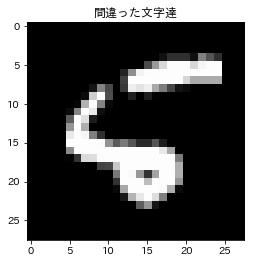

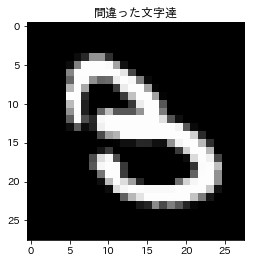

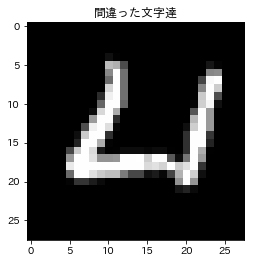

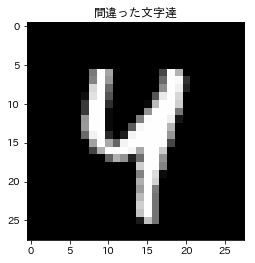

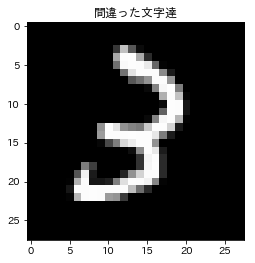

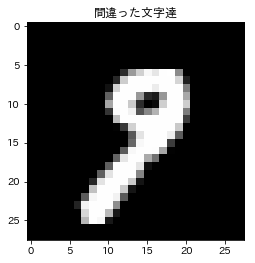

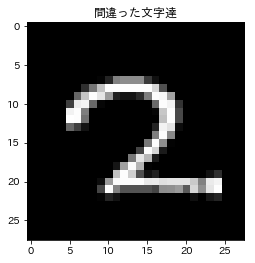

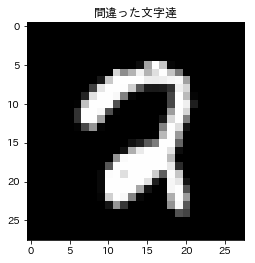

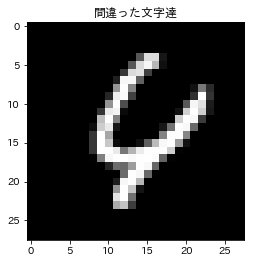

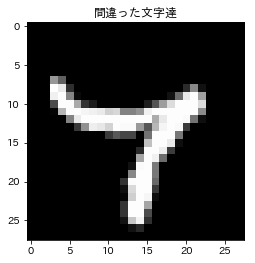

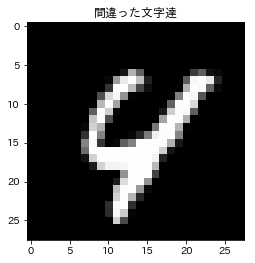

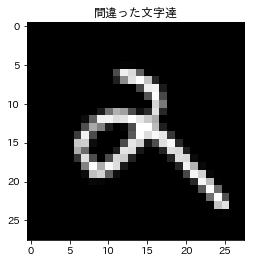

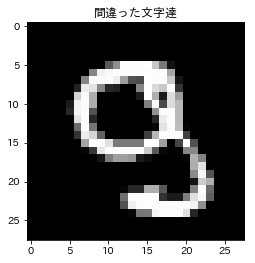

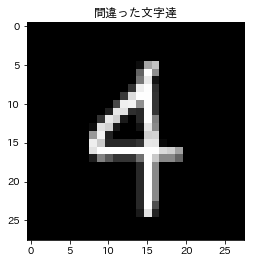

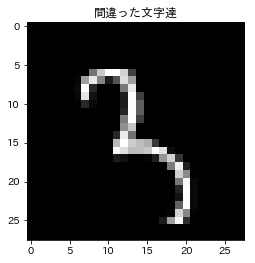

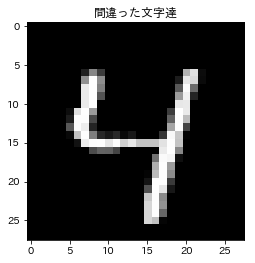

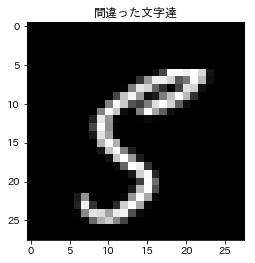

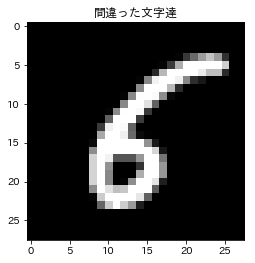

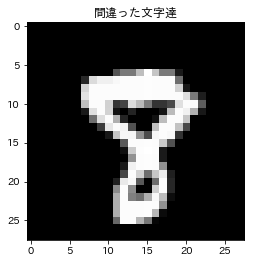

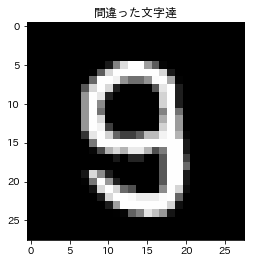

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
index = np.where(pred < 1)
for i in range(20):
    image = X_test[index[0][i]].reshape(28,28)
    # X_train[index]: (784,)
    # image: (28, 28)
    plt.imshow(image, 'gray')
    plt.title('間違った文字達')
    plt.show()

まあまあ精度がいい感じ